In [8]:
import pandas as pd

# Load the dataset
df = pd.read_csv(r"C:\Users\Tian\Desktop\NLP_Task7\Datasets\Corona_NLP_train.csv", encoding='latin1')
print(df.columns)
print(df[['OriginalTweet', 'Sentiment']].head())


Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')
                                       OriginalTweet           Sentiment
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral
1  advice Talk to your neighbours family to excha...            Positive
2  Coronavirus Australia: Woolworths to give elde...            Positive
3  My food stock is not the only one which is emp...            Positive
4  Me, ready to go at supermarket during the #COV...  Extremely Negative


In [9]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www.\S+", "", text)  # remove links
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    text = re.sub(r"\d+", "", text)  # remove numbers
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words and len(w) > 1]
    return " ".join(words)

df['clean_text'] = df['OriginalTweet'].apply(clean_text)


In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['label'] = le.fit_transform(df['Sentiment'])  # Converts 'Positive' → 2, etc.


In [11]:
from sklearn.model_selection import train_test_split

X = df['clean_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


In [13]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train_vec, y_train)


LogisticRegression(max_iter=1000)

Accuracy: 0.5739795918367347

Classification Report:
                     precision    recall  f1-score   support

Extremely Negative       0.63      0.51      0.56      1056
Extremely Positive       0.68      0.55      0.61      1330
          Negative       0.52      0.51      0.51      2006
           Neutral       0.62      0.67      0.64      1553
          Positive       0.53      0.61      0.57      2287

          accuracy                           0.57      8232
         macro avg       0.59      0.57      0.58      8232
      weighted avg       0.58      0.57      0.57      8232



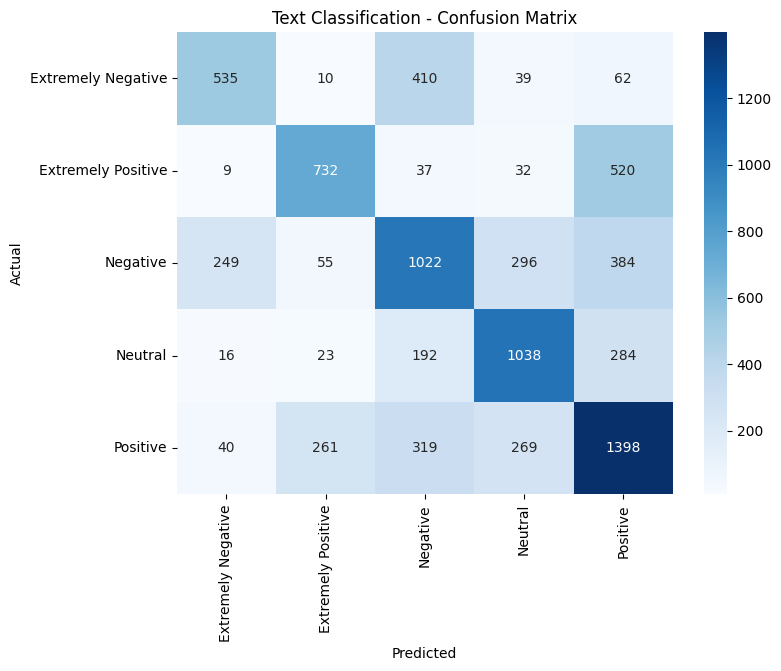

In [14]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = model.predict(X_test_vec)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Text Classification - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define Feedforward Neural Net
class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.dropout(self.relu(self.fc1(x)))
        return self.fc2(x)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_vec.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_vec.toarray(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create DataLoader objects
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize model
input_dim = X_train_tensor.shape[1]
hidden_dim = 256
output_dim = len(le.classes_)

model = FFNN(input_dim, hidden_dim, output_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(5):
    model.train()
    total_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

# Evaluation
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

from sklearn.metrics import classification_report
print(classification_report(all_targets, all_preds, target_names=le.classes_))

NameError: name 'X_train_vec' is not defined